In [13]:
import tensorflow.keras as k
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [14]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt

In [15]:
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [16]:
def create_char_vectorizer(training_corpus):
    to_characters = k.preprocessing.text.Tokenizer(char_level=True, oov_token='<OOV>', filters='\t\n')
    to_characters.fit_on_texts(training_corpus)

    return to_characters


def create_word_vectorizer(training_corpus):
    word_vectorizer = CountVectorizer(
        stop_words=None,
        min_df=5,
        token_pattern=r'&\w+;|[:/&?=.\[\]\\]|%\w{2}|[-_\w\d]+',
        analyzer='word',
        max_features=500
    )
    word_vectorizer.fit(training_corpus)

    return word_vectorizer

In [17]:
def load_data(split_ratio=None, random_state=42):
    data = pd.read_csv("all_ita_final.csv")
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
    if split_ratio is None:
        data_train = data_validation = None
    else:
        data_train, data_validation = train_test_split(
            data,
            test_size=split_ratio,
            stratify=data['Label'],
            shuffle=True,
            random_state=42
        )

    return data_train, data_validation, data



data_train, data_validation, data = load_data(split_ratio=0.3, random_state=42)

In [19]:
word_vectorizer = create_word_vectorizer(data_train['Domain'])
LW = len(word_vectorizer.vocabulary_)

print('Word vocab size:', LW)

Word vocab size: 119


In [20]:
def postpad_to(sequence, to):
    return k.preprocessing.sequence.pad_sequences(sequence, to, padding='post', truncating='post')


def map_text(X):
    if X[-1] == '/':
        X = X[:-1]
    return X

def create_dataset_generator(word_vectorizer, char_vectorizer, data: pd.DataFrame, one_hot=False, vec_length=200):
    assert word_vectorizer is not None or char_vectorizer is not None

    if word_vectorizer is not None:
        word_tokenizer = word_vectorizer.build_tokenizer()

    def gen():
        for row in data.iterrows():
            out_dict = dict()

            url = row[1].Domain
            _type = row[1].Label
            if one_hot:
                target = tf.squeeze(tf.one_hot([_type], depth=2))
            else:
                target = tf.squeeze(_type)

            if word_vectorizer is not None:
                wv = tf.constant(postpad_to(
                    [[word_vectorizer.vocabulary_.get(a, -1) + 2 for a in word_tokenizer(url)]]  # 0 = padding, 1 = OOV
                    , vec_length), name='word')
                out_dict['word'] = tf.squeeze(wv)

            if char_vectorizer is not None:
                cv = tf.constant(postpad_to(char_vectorizer.texts_to_sequences([url]), vec_length), name='char')
                out_dict['char'] = tf.squeeze(cv)

            yield out_dict, target

    output_types, output_shapes = dict(), dict()
    if word_vectorizer is not None:
        output_types['word'] = tf.float64
        output_shapes['word'] = tf.TensorShape([vec_length])
    if char_vectorizer is not None:
        output_types['char'] = tf.float64
        output_shapes['char'] = tf.TensorShape([vec_length])

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(output_types, tf.int32),
        output_shapes=(output_shapes, tf.TensorShape([] if not one_hot else [2]))
    )

    return ds

In [21]:
dataset_train = create_dataset_generator(word_vectorizer, None, data_train).shuffle(10000).prefetch(10000)#.batch(15*1024)

dataset_validation = create_dataset_generator(word_vectorizer, None, data_validation).shuffle(10000).prefetch(10000)#.batch(15*1024)

print('Train:', dataset_train.element_spec, '\nValid:', dataset_validation.element_spec)

Train: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Valid: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word (InputLayer)              [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 16)      1936        ['word[0][0]']                   
                                                                                                  
 word_conv_3 (Conv1D)           (None, 200, 32)      1568        ['embedding_2[0][0]']            
                                                                                                  
 word_conv_5 (Conv1D)           (None, 200, 32)      2592        ['embedding_2[0][0]']            
                                                                                            

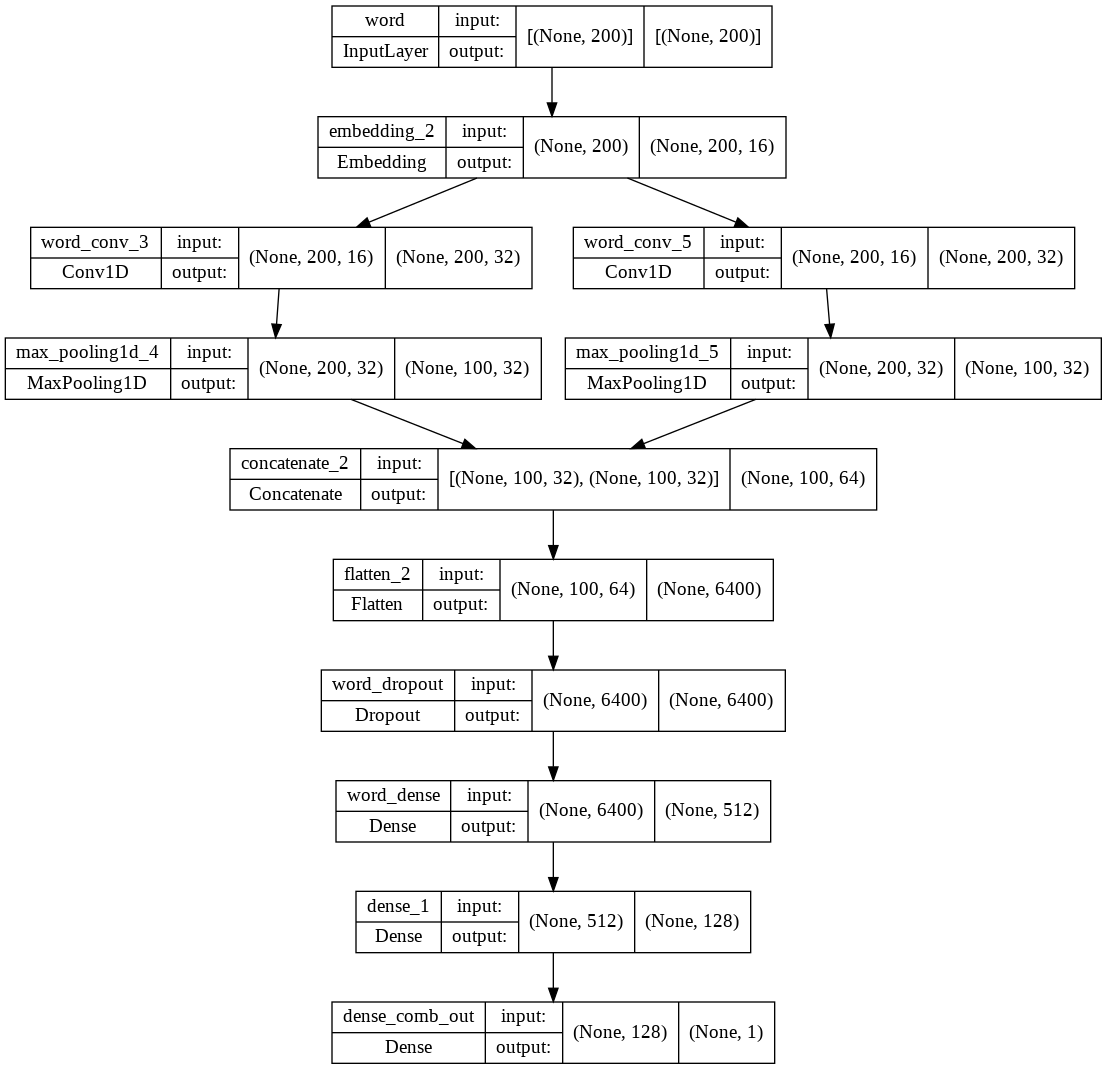

In [22]:
def create_conv_subnet(input_layer, conv_kernel_sizes, prefix=''):
    convolutions = list()
    for kernel_size in conv_kernel_sizes:
        x = k.layers.Conv1D(
            filters=32,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            name=f'{prefix}_conv_{kernel_size}'
        )(input_layer)
        x = k.layers.MaxPool1D()(x)
        convolutions.append(x)

    x = k.layers.concatenate(convolutions, axis=2)
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'{prefix}_dropout')(x)
    x = k.layers.Dense(512, name=f'{prefix}_dense', activation='relu')(x)
    return x

def create_url_net(input_length, emb_dim, conv_kernel_sizes):
    word_input = k.layers.Input(shape=[input_length], name='word')

    x = create_conv_subnet(
        k.layers.Embedding(2+LW, emb_dim, mask_zero=True)(word_input),
        conv_kernel_sizes,
        'word'
    )

    x = k.layers.Dense(128, activation='relu', name='dense_1')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[word_input], outputs=[x])
    return model

model = create_url_net(
    input_length=200,
    emb_dim=16,
    conv_kernel_sizes=[3,5]
)
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [23]:
bs=256*8

model.fit(
    dataset_train.batch(bs),
    epochs=10,
    validation_data=dataset_validation.batch(bs),
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./checkpoints', verbose=0)
    ],
)

Epoch 1/10
      2/Unknown - 3s 326ms/step - loss: 0.6928 - binary_accuracy: 0.5098INFO:tensorflow:Assets written to: ./checkpoints/assets
2/2 [==============================] - 5s 2s/step - loss: 0.6928 - binary_accuracy: 0.5098 - val_loss: 0.6906 - val_binary_accuracy: 0.6646
Epoch 2/10
2/2 [==============================] - 5s 3s/step - loss: 0.6910 - binary_accuracy: 0.5882 - val_loss: 0.6887 - val_binary_accuracy: 0.5665
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 0.6898 - binary_accuracy: 0.6077 - val_loss: 0.6868 - val_binary_accuracy: 0.7190
Epoch 4/10
2/2 [==============================] - 6s 3s/step - loss: 0.6876 - binary_accuracy: 0.6487 - val_loss: 0.6846 - val_binary_accuracy: 0.5620
Epoch 5/10
2/2 [==============================] - 5s 3s/step - loss: 0.6854 - binary_accuracy: 0.6219 - val_loss: 0.6825 - val_binary_accuracy: 0.6137
Epoch 6/10
2/2 [==============================] - 6s 3s/step - loss: 0.6833 - binary_accuracy: 0.5894 - val_loss: 0.6

In [12]:
model.save('full_convolution')

INFO:tensorflow:Assets written to: full_convolution_combined/assets


In [ ]:
bs=256*8
model = k.models.load_model('full_convolution')

In [24]:
X_validation, y_validation = np.array([*dataset_validation.as_numpy_iterator()]).T
X_validation = np.array([item['word'] for item in X_validation])

In [25]:
X_validation2 = tf.data.Dataset.from_tensor_slices(((X_validation),)).batch(bs)
y_validation = y_validation.astype('int32')

y_hat = model.predict(X_validation2).ravel()

In [26]:
fpr, tpr, thresholds = roc_curve(y_validation, y_hat)
auc_ = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(-fpr + tpr)]

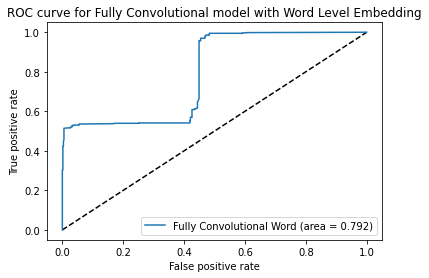

In [27]:
model_name = "Fully Convolutional Word"
model_full_name = "Fully Convolutional model with Word Level Embedding"

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_:.3f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for {model_full_name}')
plt.legend(loc='best')
plt.savefig(f'./{model_name.replace(" ", "_").lower()}_roc.pdf')
plt.show()

In [28]:
y_hat_01 = np.zeros_like(y_hat)
y_hat_01[y_hat >= best_threshold] = 1

np.unique(y_hat_01)

array([0., 1.], dtype=float32)

In [29]:
precision_recall_fscore_support(y_validation, y_hat_01, beta=1, average='binary'), \
    tpr[np.argmax(-fpr + tpr)], fpr[np.argmax(-fpr + tpr)], \
    accuracy_score(y_validation, y_hat_01)

((0.6804511278195489, 0.9696428571428571, 0.7997054491899853, None),
 0.9696428571428571,
 0.45454545454545453,
 0.7573595004460303)

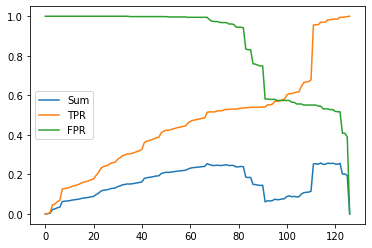

In [30]:
plt.plot((-fpr + tpr) / 2, label='Sum')
plt.plot(tpr, label='TPR')
plt.plot(1-fpr, label='FPR')
plt.legend()

In [ ]:
np.save("fpr_tpr/fccombi-fpr", fpr)
np.save("fpr_tpr/fccombi-tpr", tpr)

FileNotFoundError: ignored